In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV, ElasticNetCV, LassoCV, Lasso, ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingCVRegressor

In [2]:
# check missing values
def check_nan(df, k):
    total_na = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum() / df.isnull().count()) * 100).sort_values(ascending=False)
    missing_data = pd.concat([total_na, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data.reset_index()
    missing_data.columns = ['Name', 'Total', 'Percent']
    print(missing_data[:k])

In [3]:
# add features
def concat_features(df_train, df_test):
    schools01 = pd.read_csv('data/primary_school_01.csv', sep=',')
    schools01_test = pd.read_csv('data/primary_school_01_test.csv', sep=',')
    shopping02 = pd.read_csv('data/shopping_02.csv', sep=',')
    shopping02_test = pd.read_csv('data/shopping_02_test.csv', sep=',')    
    hawker_03 = pd.read_csv('data/hawker_03.csv', sep=',')
    hawker_03_test = pd.read_csv('data/hawker_03_test.csv', sep=',')
    train_03 = pd.read_csv('data/train_03.csv', sep=',')
    train_03_test = pd.read_csv('data/train_03_test.csv', sep=',')
    
    train_data = pd.concat([df_train[df_train.columns.values[:-1]], schools01, shopping02, hawker_03, train_03, df_train['price']], axis=1)
    test_data = pd.concat([df_test, schools01_test, shopping02_test, hawker_03_test, train_03_test], axis=1)
    
    train_data['bed_bath_ratio'] = train_data['bedrooms']/train_data['bathrooms']
    test_data['bed_bath_ratio'] = test_data['bedrooms']/test_data['bathrooms']
    return train_data, test_data

In [8]:
# read train and test data
df_train = pd.read_csv('data/train_data_cleaned.csv', sep=',')
df_test = pd.read_csv('data/test_data_cleaned.csv', sep=',')
train_len = df_train.shape[0]
print(df_train.shape, df_test.shape)

(25714, 16) (7500, 15)


In [9]:
train_data, test_data = concat_features(df_train, df_test)
print(train_data.shape, test_data.shape)

(25714, 21) (7500, 20)


In [10]:
train_labels = train_data.price
train_data = train_data.drop(columns = ['price'])
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data = all_data.drop(columns=['lng'])
all_data.shape

(33214, 19)

In [11]:
# label encoder
le_cols = ['name','street','planning_area','subszone','built_year']
for c in le_cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))
all_data.shape

# one-hot encoding
all_data = pd.get_dummies(all_data, dummy_na=False)
print(all_data.shape)

(33214, 26)


In [12]:
# use rmse to simulate the evaluation in the leaderboard and estimate the score
def self_evaluation(df_sub):
    df_gt = pd.read_csv('submission_0305_1.csv', sep=',')
    score = ((df_gt['Predicted'] - df_sub['Predicted']) ** 2).mean() ** .5
    df_gt1 = pd.read_csv('submission_0228.csv', sep=',')
    score1 = ((df_gt1['Predicted'] - df_sub['Predicted']) ** 2).mean() ** .5
    df_gt2 = pd.read_csv('submission_0326_4.csv', sep=',')
    score2 = ((df_gt2['Predicted'] - df_sub['Predicted']) ** 2).mean() ** .5
    df_gt3 = pd.read_csv('results/submission_rf_0.97630.csv', sep=',')
    score3 = ((df_gt3['Predicted'] - df_sub['Predicted']) ** 2).mean() ** .5
    print('score-0305: ', score)
    print('score-0228: ', score1)
    print('score-0326: ', score2)
    print('score-best: ', score3)
    return score

In [41]:
# *******************Linear model*******************
def get_model():
    net = nn.Sequential(nn.Linear(in_features, 64),
                        nn.ReLU(),
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.Linear(32, 1),)
    return net

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Adam optimization
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_model()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_model()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
    test_data['Predicted'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([df_id['Id'], test_data['Predicted']], axis=1)
    return submission, train_ls

In [14]:
# initialization for linear model
all_data_linear = all_data.copy()
all_data_linear = all_data_linear.drop(columns = ['name', 'street'])
numeric_attributes = ['bedrooms','bathrooms','no_of_units','area_size','primary_school_0to1','shopping_0to2','hawker_0to3', 'train_0to3']
all_data_linear[numeric_attributes] = all_data_linear[numeric_attributes].apply(lambda x: (x - x.mean()) / (x.std()))
train_data_linear = all_data_linear[:train_len]
test_data_linear = all_data_linear[train_len:]
train_attributes = torch.tensor(train_data_linear.values, dtype=torch.float32)
test_attributes = torch.tensor(test_data_linear.values, dtype=torch.float32)
train_labels_linear = torch.tensor(train_labels.values.reshape(-1, 1), dtype=torch.float32)
loss = nn.MSELoss()
in_features = train_attributes.shape[1]

fold 1, train log rmse 0.165257, valid log rmse 0.170067
fold 2, train log rmse 0.174172, valid log rmse 0.174538
fold 3, train log rmse 0.172587, valid log rmse 0.171089
fold 4, train log rmse 0.189709, valid log rmse 0.197508
fold 5, train log rmse 0.168632, valid log rmse 0.181267
5-fold cross-validation: average train log rmse: 0.174071, average test log rmse: 0.178894


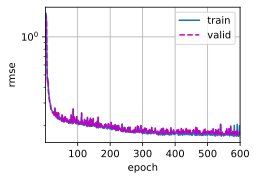

In [87]:
# train linear model
k, num_epochs, lr, weight_decay, batch_size = 5, 600, 0.01, 0, 64 # adjust hyperparameter
train_l, valid_l = k_fold(k, train_attributes, train_labels_linear, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold cross-validation: average train log rmse: {float(train_l):f}, '
      f'average test log rmse: {float(valid_l):f}')

In [90]:
# predict linear model
submission, train_ls = train_and_pred(train_attributes, test_attributes, train_labels_linear, test_data,
               num_epochs, lr, weight_decay, batch_size)
score = self_evaluation(submission)
submission.to_csv('results/submission_linear_rmsle'+str(float(train_ls[-1]))[:6]+'.csv', index=False)

In [20]:
# Define error metrics
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# k-fold Cross Validation
# set verbose=3 for more details
def rmsle_cross_val(X_train, y_train, n_folds, model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return rmse

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
# *******************Lasso model*******************
# lasso_alphas = [0.00001, 0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005]
# model_lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1000,alphas =lasso_alphas, random_state=42, cv=kfolds))
# model_lasso = make_pipeline(RobustScaler(), Lasso(max_iter=1000, alpha =0.00005, random_state=42))
model_lasso = Lasso(max_iter=1000, alpha =0.00005, tol=0.1, random_state=42)
score_lasso = rmsle_cross_val(train_data_linear, train_labels, 5, model_lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))
model_lasso.fit(train_data_linear.values, train_labels.values)
model_lasso_pred = model_lasso.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lasso_pred), columns = ['Predicted'])
model_lasso_pred, df_pred['Predicted']
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('results/submission_lasso_rmse'+str(float(score_lasso.mean()))[:7]+'.csv', index=False)

Lasso score: 1897289.2911 (112774.1932)



In [22]:
# *******************ENet model*******************
# enet_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
# enet_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
model_ENet = make_pipeline(RobustScaler(), ElasticNet(max_iter=3000, alpha=0.0005, l1_ratio=0.8, tol=0.2, random_state=42))
score_ENet = rmsle_cross_val(train_data_linear, train_labels, 5, model_ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score_ENet.mean(), score_ENet.std()))
model_ENet.fit(train_data_linear.values, train_labels.values)
model_ENet_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ENet_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('results/submission_enet_rmse'+str(float(score_ENet.mean()))[:7]+'.csv', index=False)

ElasticNet score: 1960749.5433 (103860.5133)



In [23]:
# *******************Ridge model*******************
ridge_alphas = [1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
model_ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kfolds))
# model_ridge = make_pipeline(RobustScaler(), Ridge(max_iter=1000, alpha=0.1))
score_ridge = rmsle_cross_val(train_data_linear, train_labels, 5, model_ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))
model_ridge.fit(train_data_linear.values, train_labels.values)
model_ridge_pred = model_ENet.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_ridge_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('results/submission_ridge_rmse'+str(float(score_ridge.mean()))[:7]+'.csv', index=False)

Ridge score: 1896292.6282 (116982.2560)



In [24]:
# *******************SVR model*******************
# C = [0.1, 0.5, 1, 50, 100, 1000]
# epsilon = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
# C:5 - 0.1163 (0.0032), C:10 - 0.1140 (0.0034), epsilon: 0.05 - 0.1105 (0.0039)
model_svr = make_pipeline(RobustScaler(), SVR(C=10, epsilon=0.05, gamma='scale'))
score_svr = rmsle_cross_val(train_data_linear, np.log(train_labels), 5, model_svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score_svr.mean(), score_svr.std()))

model_svr.fit(train_data_linear.values, np.log(train_labels.values))
model_svr_pred = model_svr.predict(test_data_linear.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(np.exp(model_svr_pred)), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
# self_evaluation(submission)
submission.to_csv('results/submission_svr_rmsle'+str(float(score_svr.mean()))[:7]+'.csv', index=False)

SVR score: 0.1084 (0.0047)



In [25]:
# init train data and test data for non-linear model
all_data_ensemble = all_data.copy()
all_data_ensemble = all_data_ensemble.drop(columns=['name','street'])
train_data_ensemble = all_data_ensemble[:train_len]
test_data_ensemble = all_data_ensemble[train_len:]
train_data_ensemble.shape, test_data_ensemble.shape

((25714, 24), (7500, 24))

In [30]:
# *******************Random Forest model*******************
# use grid search to produce a baseline rf model
model_rf = RandomForestRegressor(oob_score=True, random_state=3, n_jobs=-1)
params ={
    'n_estimators': [1300],# [800, 900, 1000, 1200, 1500],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [None, 0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8, 10, 15, 20],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_ensemble, train_labels)
    if model_rf.oob_score_ > best_score:
        best_score = model_rf.oob_score_
        best_grid = g
        print('oob:', best_score, best_grid)
# oob: 0.9764868974915827 {'max_depth': 35, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1300}

oob: 0.9764868974915827 {'max_depth': 35, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1300}


In [31]:
# check feature importance
def RF_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_ensemble, train_labels)
feature_imp = RF_importance(model_rf, train_data_ensemble)
print(model_rf.oob_score_)
print(feature_imp)

0.9762910106508067
                           cols       imp
9                     area_size  0.642051
1                     bathrooms  0.123987
11                shopping_0to2  0.043892
0                      bedrooms  0.038863
4                      subszone  0.026233
5                           lat  0.025676
13                   train_0to3  0.015375
8                   no_of_units  0.013706
7                    built_year  0.011856
2                      district  0.011513
14               bed_bath_ratio  0.011182
12                  hawker_0to3  0.009119
10          primary_school_0to1  0.008942
19        region_central region  0.007707
3                 planning_area  0.005637
6                        tenure  0.001649
15              model_apartment  0.001168
16            model_condominium  0.001145
23           region_west region  0.000119
20           region_east region  0.000104
18            model_walk-up apt  0.000035
22     region_north-east region  0.000030
17  model_execu

In [33]:
# feature selection
Threshold = 0.0009
to_keep = feature_imp[feature_imp.imp>Threshold].cols
to_keep = [col for _, col in to_keep.items()]
print(to_keep)
df_keep = train_data_ensemble[to_keep].copy()
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(df_keep, train_labels)
score_rf = rmsle_cross_val(train_data_ensemble, train_labels, 5, model_rf)
print(model_rf.oob_score_, score_rf.mean())

['area_size', 'bathrooms', 'shopping_0to2', 'bedrooms', 'subszone', 'lat', 'train_0to3', 'no_of_units', 'built_year', 'district', 'bed_bath_ratio', 'hawker_0to3', 'primary_school_0to1', 'region_central region', 'planning_area', 'tenure', 'model_apartment', 'model_condominium']
0.9760825088344165 723405.3390714184


In [35]:
# deep selection
# keep_cols imp >= 0.01
keep_cols = ['area_size', 'bathrooms', 'shopping_0to2', 'bedrooms', 'subszone', 'lat', 'train_0to3', 
             'no_of_units', 'built_year', 'district', 'bed_bath_ratio', 'primary_school_0to1', 'hawker_0to3']
cols = to_keep
scores = []
feats = []
for col in cols:
    tmp = to_keep.copy()
    if col in keep_cols:
        continue
    tmp.remove(col)
    df_tmp = train_data_ensemble[tmp].copy()
    model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1300, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
    model_rf.fit(df_tmp, train_labels)
    scores.append(model_rf.oob_score_)
    feats.append(col)

to_del = sorted(zip(scores, feats), reverse=True)
to_del

[(0.9764162666650514, 'region_central region'),
 (0.976315851620543, 'model_apartment'),
 (0.9762884494460968, 'planning_area'),
 (0.975959941369601, 'tenure'),
 (0.975899725118432, 'model_condominium')]

In [37]:
# fine-tuning
# delete increase less than 0.0001
to_keep_final = ['area_size', 'bathrooms', 'shopping_0to2', 'bedrooms', 'subszone', 'lat', 'train_0to3', 
                 'no_of_units', 'built_year', 'district', 'bed_bath_ratio', 'primary_school_0to1', 'hawker_0to3',
                 'model_condominium', 'tenure']
train_data_final = train_data_ensemble[to_keep_final].copy()
model_rf = RandomForestRegressor(oob_score=True, n_jobs=-1)
params ={
    'n_estimators': [1200, 1250,1280],# [1200, 1250, 1280, 1300, 1350, 1400],
    'min_samples_leaf': [1],# [1, 2, 3, 5, 10, 25],
    'max_features': [0.5],# [0.5, 'sqrt', 'log2'],
    'max_depth': [35],# [5, 6, 7, 8],
    'min_samples_split': [2]# [2, 3, 4]
}

best_score = 0
for g in ParameterGrid(params):
    model_rf.set_params(**g)
    model_rf.fit(train_data_final, train_labels)
    if model_rf.oob_score_ > best_score:
        score_rf = rmsle_cross_val(train_data_final, train_labels, 5, model_rf)
        best_score = model_rf.oob_score_
        best_grid = g
        print('best oob:', best_score, best_grid, 'score:', score_rf.mean())

best oob: 0.9764437583184912 {'max_depth': 35, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200} score: 714747.7621518585
best oob: 0.9764479898419359 {'max_depth': 35, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1250} score: 719626.166418285


In [38]:
model_rf = RandomForestRegressor(n_jobs=-1, n_estimators=1250, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_rf.fit(train_data_final, train_labels)
test_data_final = test_data_ensemble[to_keep_final]
model_rf_pred=model_rf.predict(test_data_final)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_rf_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
self_evaluation(submission)
submission.to_csv('results/submission_rf_'+str(best_score)[:7]+'.csv', index=False)

score-0305:  320697.80248163815
score-0228:  390377.5042031351
score-0326:  375300.37141234515
score-best:  139608.04054716154


In [40]:
# *******************GBoost model*******************
model_GBoost = GradientBoostingRegressor(n_estimators=7000, learning_rate=0.1,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
score_GBoost = rmsle_cross_val(train_data_ensemble, np.log(train_labels), 5, model_GBoost)
print("GradientBoostingRegressor score: {:.4f} ({:.4f})\n".format(score_GBoost.mean(), score_GBoost.std()))

model_GBoost.fit(train_data_ensemble.values, train_labels.values)
model_gb_pred = model_GBoost.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_gb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
self_evaluation(submission)
submission.to_csv('results/submission_gb_rmsle'+str(float(score_GBoost.mean()))[:7]+'.csv', index=False)

GradientBoostingRegressor score: 0.0899 (0.0049)

score-0305:  372020.9971563928
score-0228:  427348.02561755944
score-0326:  397547.2657544148
score-best:  359746.89476228185


In [43]:
# *******************XGB model*******************
# xgb_params = dict(
#     max_depth=6,           # maximum depth of each tree - try 2 to 10
#     learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
#     n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
#     min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
#     colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
#     subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
#     reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
#     reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
#     num_parallel_tree=1,   # set > 1 for boosted random forests
# )
model_xgb = xgb.XGBRegressor(learning_rate=0.01, gamma=0,
                             max_depth=5, min_child_weight = 1,
                             n_estimators=6000, colsample_bytree=0.6,
                             reg_alpha=0.5, reg_lambda=1.0,
                             subsample=0.7, random_state = 42, nthread = -1)
score_xgb = rmsle_cross_val(train_data_ensemble, np.log(train_labels), 5, model_xgb)
print("XGB score: {:.4f} ({:.4f})\n".format(score_xgb.mean(), score_xgb.std()))

model_xgb.fit(train_data_ensemble.values, train_labels.values)
model_xgb_pred = model_xgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_xgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
self_evaluation(submission)
submission.to_csv('results/submission_xgb_rmsle'+str(float(score_xgb.mean()))[:7]+'.csv', index=False)

XGB score: 0.0937 (0.0045)

score-0305:  350449.7187959784
score-0228:  389152.8269360083
score-0326:  374759.86820148054
score-best:  359316.1284309187


In [58]:
# *******************LightGBM model*******************
# Use large max_bin (may be slower)
# Use small learning_rate with large num_iterations
# Use large num_leaves (may cause over-fitting)
model_lgb = lgb.LGBMRegressor(objective='regression', 
                       num_leaves=25, learning_rate=0.05, 
                       max_bin = 200, n_estimators=1000,
                       random_state=42)
score_lgb = rmsle_cross_val(train_data_ensemble, np.log(train_labels), 5, model_lgb)
print("LGB score: {:.4f} ({:.4f})\n".format(score_lgb.mean(), score_lgb.std()))

model_lgb.fit(train_data_ensemble.values, train_labels.values)
model_lgb_pred = model_lgb.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_lgb_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
self_evaluation(submission)
submission.to_csv('results/submission_lgb_rmsle'+str(float(score_lgb.mean()))[:7]+'.csv', index=False)

LGB score: 0.0945 (0.0042)

score-0305:  345722.1850253656
score-0228:  409784.4109252725
score-0326:  348964.5992223786
score-best:  393101.3738851027


In [57]:
# *******************RF model*******************
model_RF = RandomForestRegressor(n_jobs=-1, n_estimators=1250, oob_score=True, max_depth=35, min_samples_leaf=1, min_samples_split=2, max_features=0.5)
model_RF.fit(train_data_ensemble.values, train_labels.values)

RandomForestRegressor(max_depth=35, max_features=0.5, n_estimators=1250,
                      n_jobs=-1, oob_score=True)

In [59]:
# *******************Stacking model*******************
model_stack = StackingCVRegressor(regressors=(model_GBoost, model_xgb, model_lgb),
                                meta_regressor=model_rf,
                                use_features_in_secondary=True)
score_stack = rmsle_cross_val(train_data_ensemble, np.log(train_labels), 5, model_stack)
print("Stacked score: {:.4f} ({:.4f})\n".format(score_stack.mean(), score_stack.std()))
# fitting stacked model
model_stack.fit(train_data_ensemble.values, train_labels.values)
model_stack_pred = model_stack.predict(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_stack_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
self_evaluation(submission)
submission.to_csv('results/submission_stacked_rmsle'+str(float(score_stack.mean()))[:7]+'.csv', index=False)

Stacked score: 0.0897 (0.0052)

score-0305:  333924.8970440155
score-0228:  393282.2414623713
score-0326:  366896.7549917645
score-best:  307944.7063187514


In [74]:
# *******************Blend models/Weighting*******************
def blended_predictions(X):
    return ((0.05 * model_GBoost.predict(X)) + \
            (0.1 * model_xgb.predict(X)) + \
            (0.1 * model_lgb.predict(X)) + \
            (0.55 * model_RF.predict(X)) + \
            (0.2 * model_stack.predict(X)))

model_blend_pred = blended_predictions(train_data_ensemble.values)
score_blend = rmse(np.log(train_labels.values), np.log(model_blend_pred))
print(score_blend)

0.05588359212076447


In [76]:
model_blended_pred = blended_predictions(test_data_ensemble.values)
df_id = pd.DataFrame([id for id in range(test_data.shape[0])], columns=['Id'])
df_pred = pd.DataFrame(pd.Series(model_blended_pred), columns = ['Predicted'])
submission = pd.concat([df_id['Id'], df_pred['Predicted']], axis=1)
self_evaluation(submission)
submission.to_csv('results/submission_blended_rmsle'+str(score_blend)[:7]+'.csv', index=False)

score-0305:  275060.0034416316
score-0228:  352031.2678572532
score-0326:  321671.80814756406
score-best:  174809.10690779946


275060.0034416316